# Model project: A Solow-Swan model with endogenous growth 

Imports and set magics:

In [11]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

The following model is the Solow-Swan model extended to include semi-endogenous growth of technology. In steady-state the level of GDP per worker is highly dependent on the growth of technology, and therefore it is interesting to examine the case of endogenous growth. 

*The four equations of the model are:* 

$Y_t = K_t^\alpha (A_t L_t)^{1-\alpha}$
 
$A_t=K_t^\phi , \phi<1$

$K_{t+1}=sY_t+(1-\delta)K_t$

$L_{t+1}=(1+n)L_t$


$Y_t$ is output, $K_t$ is capital, $A_t$ is technology and $L_t$ is the labor force. These are the variables of the model. The parameters are $\alpha, \phi, s, \delta, n$, where $\alpha$ is the output elasticity of capital and labor, $\phi$ is the return from capital to the technological level, $\delta$ is the depreciation of capital, n is the growth of labor. s is the savings which is equal to investments, since it is a closed economy. 

## Analytical solution

To solve the model we have to find the steady state value for k and y. We need to define the model in terms of effective labor units. By doing so and substituting technology and labor into the production function and capital accumulation function our model consists of two equations. Lower case letters implies a variable in terms of effective labor units.

In [12]:
# Variables and parameters defined to be shown in equations

alpha = sm.symbols("alpha")
phi = sm.symbols("phi")
delta = sm.symbols("delta")
s = sm.symbols("s")
n = sm.symbols("n")
ke = sm.symbols("k_t")
ke1 = sm.symbols("k_t+1")
ye = sm.symbols("y_t")
kss = sm.symbols("k^*")
yss = sm.symbols("y^*")

# Equations defined in effective labor units

Production = sm.Eq(ye, ke**alpha)
Capitalacc = sm.Eq(ke1/ke, (1/(1+n))*(s*ye/ke+(1-delta))**(1-phi))

display(Production)
display(Capitalacc)

Eq(y_t, k_t**alpha)

Eq(k_t+1/k_t, (-delta + 1 + s*y_t/k_t)**(1 - phi)/(n + 1))

We use SymPy to calculate the steady state values for y and k by substituting the steady state value for k and y into their respectively variables with time subscripts. We can then solve for the steady state value of k by using the solve function. To find the steady state value of y we substitute the steady state value of k into the production function.

In [13]:
Calc = Capitalacc.subs(ye, Production.rhs)
Transition = sm.Eq(Calc.lhs * ke, Calc.rhs * ke)

# We substitute the steady state values of y and k into the equations
sst = sm.Eq(kss, ke)
sst1 = sm.Eq(kss, ke1)
ysst = sm.Eq(yss, ye)

Transition_ss = Transition.subs({ke: sst.lhs, ke1: sst1.lhs})
Production_ss = Production.subs({ye: ysst.lhs, ke: sst.lhs})

# We solve for k steady state
k_ss_solve = sm.solve(Transition_ss, kss)
y_ss = Production_ss.subs(kss, k_ss_solve[0])
k_ss = sm.Eq(kss, k_ss_solve[0])

display(k_ss)
display(y_ss)

Eq(k^*, ((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))

Eq(y^*, (((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))**alpha)

We want to find a value for k and y in the steady state and to do that we define the steady state equations as functions and thereafter we use parametervalues to find a value.

In [14]:
# We define the steady state values as fundtions
k_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=k_ss_solve[0])
y_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=y_ss.rhs)

# The parameter values are defined as follows
s_val = 0.101
alpha_val = 0.33
delta_val = 0.05
phi_val = 0.5
n_val = 0.02

solk = k_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)
soly = y_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)

print(f"The steady state value of capital is {solk:.2f}")
print(f"The steady state value of output is {soly:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


## Numerical solution

We start by defining the transition equation and set all k's equal. We set the equation equal to zero by moving the left hand side k to the right side. We use the Brentq method to find the roots of the function and search in the interval [0.01,100] for a steady state k. We insert the steady state k into the production function to find the steady state y. 

In [15]:
# We define the transition equation as a function
def f(k):
    return k - k/(1+n_val) * (s_val * k**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# We find the root of the function
k = brentq(f, 0.01, 100)

y = k**alpha_val

print(f"The steady state value of capital is {k:.2f}")
print(f"The steady state value of output is {y:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


We note that both methods achieves the same results. 

# Further analysis

In the next section we wish to examine the sensitivity of the steady state values of k and y with changes in the return of learning by doing. We create a vector of values of $\phi$ from 0 up to 1. We loop our results and create a simple line plot. 

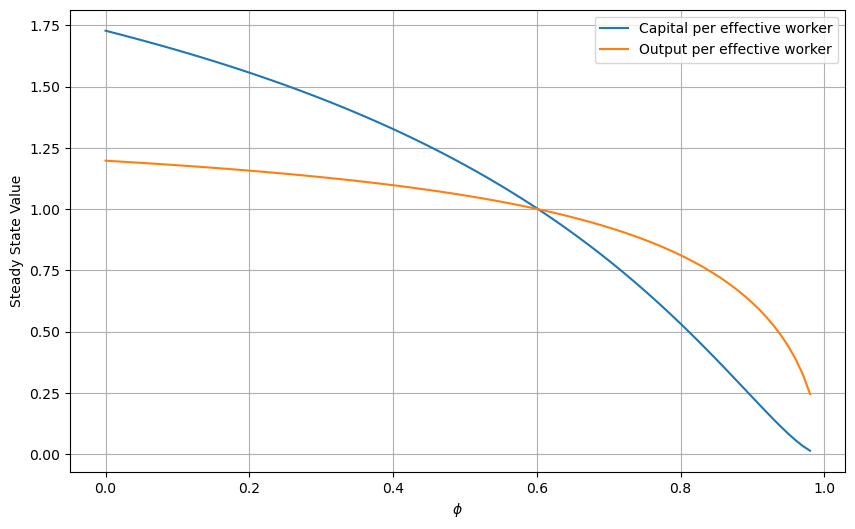

In [16]:
phi_vec = np.arange(0, 0.99, 0.01)

def f(k_phi, phi_val):
    return k_phi - k_phi/(1+n_val) * (s_val * k_phi**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# We create empy lists
k_values = []
y_values = []

# We loop over different values of phi_val
for phi_val in phi_vec:
    k_phi = brentq(f, 0.01, 100, args=(phi_val,))
    y_phi = k_phi**alpha_val
    # We append the values to the lists
    k_values.append(k_phi)
    y_values.append(y_phi)

# We create a line plot
plt.figure(figsize=(10, 6))
plt.plot(phi_vec, k_values, label='Capital per effective worker')
plt.plot(phi_vec, y_values, label='Output per effective worker')
plt.xlabel('$\phi$')
plt.ylabel('Steady State Value')
plt.legend()
plt.grid(True)
plt.show()

The steady state values of k and y are declining for an increasing value of $\phi$. Since the steady state variables are per effective worker, a lower value means a higher value of capital and output. 

The steady state technological growth rate is given as:
$g=(1+n)^{\phi/(1-\phi)}-1$,
which is equal to the growth rate of capital and output in steady state. 

In the next section we examine the sensitivity of g as the growth in labor force and return of learning by doing changes. We start by examining g for changes in n and $\phi$ seperately by keeping the other value at their baseline value. 

In [17]:
# We create vectors with values for n and phi
phi_vec_res1 = np.arange(0, 1, 0.1)
n_vec1 = np.arange(0, 0.05, 0.005)

# We solve the value of g
g_n=(1+n_vec1)**(phi_val/(1-phi_val))-1 #g_n is the growth rate of varying n's
g_phi=(1+n_val)**(phi_vec_res1/(1-phi_vec_res1))-1 #g_phi is the growth rate of varying phi's

print("g_n:")
for n, value in zip(n_vec1, g_n):
    print(f"n: {n:.3f}, g_n: {value:.2f}")

print("g_phi")
for phi, value in zip(phi_vec_res1, g_phi):
    print(f"phi: {phi:.1f}, g_phi: {value:.2f}")

g_n:
n: 0.000, g_n: 0.00
n: 0.005, g_n: 0.28
n: 0.010, g_n: 0.63
n: 0.015, g_n: 1.07
n: 0.020, g_n: 1.64
n: 0.025, g_n: 2.35
n: 0.030, g_n: 3.26
n: 0.035, g_n: 4.40
n: 0.040, g_n: 5.83
n: 0.045, g_n: 7.64
g_phi
phi: 0.0, g_phi: 0.00
phi: 0.1, g_phi: 0.00
phi: 0.2, g_phi: 0.00
phi: 0.3, g_phi: 0.01
phi: 0.4, g_phi: 0.01
phi: 0.5, g_phi: 0.02
phi: 0.6, g_phi: 0.03
phi: 0.7, g_phi: 0.05
phi: 0.8, g_phi: 0.08
phi: 0.9, g_phi: 0.20


From the output we see that both a higher n and $\phi$ leads to a higher growth rate. Furthermore we observe that the growth rate explodes for high values of labor force growth. 

We wish to analyze the combined effects of n and $\phi$ on the growth rate. To do this we create a 3D plot. 

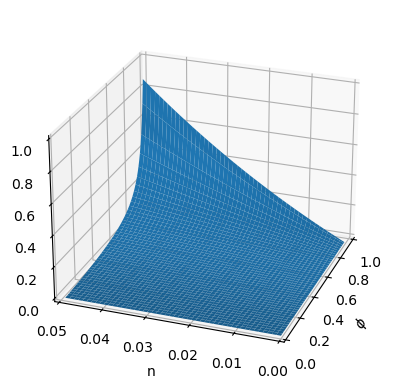

In [18]:
phi_vec_res = np.arange(0, 0.94, 0.01) # We restrict phi to maximum 0.94 to avoid explosive growth rates. 
n_vec = np.arange(0, 0.050, 0.001)

# We create a meshgrid for phi and n
phi_mesh, n_mesh = np.meshgrid(phi_vec_res, n_vec)

# We solve g for each pair of phi and n
g_mesh = (1 + n_mesh)**(phi_mesh / (1 - phi_mesh)) - 1

# We reate a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(phi_mesh, n_mesh, g_mesh)

ax.set_ylim(0, 0.05)
ax.set_xlim(0, 1)
ax.set_zlim(0, 1)

ax.view_init(elev=25, azim=200)

ax.set_xlabel('$\phi$')
ax.set_ylabel('n')
ax.set_zlabel('g')

plt.show()

# Model extension

We can improve the model by including human capital. Human capital is the skills the individual worker has, such as education, experience and IQ. The extended model looks as the following:

$Y_t = K_t^\alpha H_t^\gamma (A_t L_t)^{1-\alpha-\gamma}$
 
$A_t=(K_tH_t)^\phi , \phi<1$

$K_{t+1}=s_kY_t+(1-\delta)K_t$

$H_{t+1}=s_hY_t+(1-\delta)H_t$

$L_{t+1}=(1+n)L_t$

H is the new variable for human capital and the new equation is the equation for human capital accumulation. We now assume that the technological growth through learning by doing comes from both capital and human capital.

To solve the model we find the transition equations for $\tilde k$ and $\tilde h$ and use the assumption that in the steady state both $\tilde k$ and $\tilde h$ are constant. We solve it numerically with fsolve to take into account that there are multiple equations in steady state which brentq can not handle.  

In [19]:
# We define the values for the parameters
sh_val = 0.2
sk_val = 0.2
n_val_new = 0.025 
alfa_val = 0.33
gamma_val = 0.33
phi_val_new = 0.3

# We create a function for the two steady state equations
def equations(var):
    k, h = var
    k_trans = ((sk_val * k**(alfa_val-1)*h**gamma_val+(1-delta_val))**(1-phi_val_new)*(sh_val*k**alfa_val*h**(gamma_val-1)+(1-delta_val))**(-phi_val_new)/(1+n_val_new)-1)
    h_trans = ((sh_val * k**alfa_val*h**(gamma_val-1)+(1-delta_val))**(1-phi_val_new)*(sk_val*k**(alfa_val-1)*h**gamma_val+(1-delta_val))**(-phi_val_new)/(1+n_val_new)-1)
    return [k_trans, h_trans]

initial_guess = (1, 1)

# We solve for steady state
k,h = fsolve(equations, initial_guess)

print("The steady state value for k and h is {:.2f} and {:.2f}".format(k, h))

The steady state value for k and h is 5.27 and 5.27


In [20]:

def g(k_phi, h_phi, phi_val):
    k_trans_phi = ((sk_val * k_phi**(alfa_val-1)*h_phi**gamma_val+(1-delta_val))**(1-phi_val)*(sh_val*k_phi**alfa_val*h_phi**(gamma_val-1)+(1-delta_val))**(-phi_val)/(1+n_val_new)-1)
    h_trans_phi = ((sh_val * k_phi**alfa_val*h_phi**(gamma_val-1)+(1-delta_val))**(1-phi_val)*(sk_val*k_phi**(alfa_val-1)*h_phi**gamma_val+(1-delta_val))**(-phi_val)/(1+n_val_new)-1)
    return [k_trans_phi, h_trans_phi]


# Lists to store the values of k_phi and y_phi
k_values = []
h_values = []
y_values = []

# Loop over different values of phi_val
for phi_val in phi_vec:
    initial_guess = (1, 1)
    k_phi,h_phi = fsolve(g, initial_guess, args=(phi_val))
    # Append the values to the lists
    k_values.append(k_phi)
    h_values.append(h_phi)
    y_values.append(y_phi)

TypeError: g() missing 1 required positional argument: 'phi_val'

# Conclusion

Through our analysis we are able to conclude that a higher return of learning by doing from capital results in lower values of steady state $\tilde{k}$ and $\tilde{y}$. In turn this means that a higher $\phi$ means higher values of K and Y in steady state. We find that both higher values of $\phi$ and n results in a higher growth rate in steady state. 